## 配置引擎参数

In [3]:
from vnpy.trader.app.ctaStrategy.ctaBacktesting import BacktestingEngine, OptimizationSetting, MINUTE_DB_NAME

# 创建回测引擎对象
engine = BacktestingEngine()
# 设置回测使用的数据
engine.setBacktestingMode(engine.BAR_MODE)    # 设置引擎的回测模式为K线
engine.setDatabase(MINUTE_DB_NAME)  # 设置使用的历史数据库
engine.setStartDate('20180501',initDays=5)               # 设置回测用的数据起始日期
engine.setEndDate('20180630')
# 配置回测引擎参数
engine.setSlippage(0.2)     # 设置滑点为股指1跳
engine.setRate(1/1000)   # 设置手续费千1
engine.setSize(1)         # 设置合约大小 
engine.setPriceTick(0.1)    # 设置股指最小价格变动   
engine.setCapital(1000000)  # 设置回测本金

## 策略编写与参数设置

参数与变量的区别: 参数用来传递，变量是随着过程的赋值改变的

ArrayManager: 生成数组插入与管理数据对象

## 回测引擎修改内容
1. symbolList: 支持多品种以列表格式输入引擎
2. posDict: 可记录多个品种的多空情况

---
## CtaTemplate 内的方法

3. self.ctaEngine.initPosition(self): 将多空的仓位初始化为0
4. initData = self.loadBar(self.initDays): 初始时将一定长度的历史数据Load进来
5. self.cancelAll(): 取消所有订单
6. ArrayManger(size): 数组管理器

In [4]:
"""
这里的Demo是一个最简单的双均线策略实现
"""

from __future__ import division

from vnpy.trader.vtConstant import EMPTY_STRING, EMPTY_FLOAT
from vnpy.trader.app.ctaStrategy.ctaTemplate import (CtaTemplate, 
                                                     BarGenerator,
                                                     ArrayManager)
import talib as ta

########################################################################
# 策略继承CtaTemplate
class DoubleMaStrategy(CtaTemplate):
    """双指数均线策略Demo"""
    className = 'DoubleMaStrategy'
    author = u'用Python的交易员'
    
    # 策略交易标的的列表
    symbolList = []         # 初始化为空
    posDict = {}  # 初始化仓位字典
    
    # 多空仓位
    Longpos = EMPTY_STRING        # 多头品种仓位
    Shortpos = EMPTY_STRING       # 空头品种仓位
    
    # 策略参数
    fastWindow = 60     # 快速均线参数
    slowWindow = 240     # 慢速均线参数
    initDays = 1       # 初始化数据所用的天数
    
    # 策略变量
    fastMa0 = EMPTY_FLOAT   # 当前最新的快速EMA
    fastMa1 = EMPTY_FLOAT   # 上一根的快速EMA
    slowMa0 = EMPTY_FLOAT   # 当前最新的慢速EMA
    slowMa1 = EMPTY_FLOAT   # 上一根的慢速EMA
    
    # 参数列表，保存了参数的名称
    paramList = ['name',
                 'className',
                 'author',
                 'vtSymbol',
                 'symbolList',
                 'fastWindow',
                 'slowWindow']    
    
    # 变量列表，保存了变量的名称
    varList = ['inited',
               'trading',
               'posDict',
               'fastMa0',
               'fastMa1',
               'slowMa0',
               'slowMa1']  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        
        # 首先找到策略的父类（就是类CtaTemplate），然后把DoubleMaStrategy的对象转换为类CtaTemplate的对象
        super(DoubleMaStrategy, self).__init__(ctaEngine, setting)
        
        # 给多空仓位命名
        symbol = self.symbolList[0]
        self.Longpos = symbol.replace('.','_')+"_LONG"
        self.Shortpos = symbol.replace('.','_')+"_SHORT"
        
        # 生成Bar数组
        self.amDict = {
            sym: ArrayManager(size=self.slowWindow+10)
            for sym in self.symbolList
        }
      
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略初始化')
        # 初始化仓位字典
        self.ctaEngine.initPosition(self)
        # 初始化历史数据天数
        initData = self.loadBar(self.initDays)
        for bar in initData:
            self.onBar(bar)
        
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.writeCtaLog(u'双EMA演示策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        pass
        
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        self.cancelAll() # 全部撤单
        symbol = bar.vtSymbol
        
        am = self.amDict[symbol]
        am.updateBar(bar)
        if not am.inited:
            return

        # 计算策略需要的信号-------------------------------------------------
        fastMa = ta.EMA(am.close, self.fastWindow)
       
        self.fastMa0 = fastMa[-1]
        self.fastMa1 = fastMa[-2]
        
        slowMa = ta.EMA(am.close, self.slowWindow)
        self.slowMa0 = slowMa[-1]
        self.slowMa1 = slowMa[-2]

        crossOver = self.fastMa0>self.slowMa0 and self.fastMa1<self.slowMa1     # 金叉上穿
        crossBelow = self.fastMa0<self.slowMa0 and self.fastMa1>self.slowMa1    # 死叉下穿
        
        # 构建进出场逻辑-------------------------------------------------
        # 金叉和死叉的条件是互斥
        if crossOver:
            # 如果金叉时手头没有持仓，则直接做多
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.buy(symbol,bar.close, 1)
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[self.Shortpos] == 1:
                self.cover(symbol,bar.close, 1)
                self.buy(symbol,bar.close, 1)

        # 死叉和金叉相反
        elif crossBelow:
            if (self.posDict[self.Longpos]==0) and (self.posDict[self.Shortpos]==0):
                self.short(symbol,bar.close, 1)
            elif self.posDict[self.Longpos] == 1:
                self.sell(symbol,bar.close, 1)
                self.short(symbol,bar.close, 1)
        
        # 发出状态更新事件
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        pass
    
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

In [6]:
# 在引擎中创建策略对象
d = {'fastWindow': 20 , 'symbolList':['tBTCUSD:bitfinex']}                    # 策略参数配置
engine.initStrategy(DoubleMaStrategy, d)    # 创建策略对象
engine.runBacktesting()

2018-07-14 14:07:40.455232	开始回测
2018-07-14 14:07:40.455232	策略初始化
2018-07-14 14:07:40.455232	载入历史数据。数据范围:[20180426,20180501)
2018-07-14 14:07:41.181490	载入完成，数据量：7200
2018-07-14 14:07:41.260409	策略初始化完成
2018-07-14 14:07:41.260409	策略启动完成
2018-07-14 14:07:41.260409	开始回放回测数据,回测范围:[20180501,20180701)
2018-07-14 14:07:41.261408	载入历史数据。数据范围:[20180501,20180701)
2018-07-14 14:07:48.614900	载入完成，数据量：87264
2018-07-14 14:07:48.615900	当前回放数据:[20180501,20180701)
2018-07-14 14:07:50.345135	数据回放结束ss: 100%    


In [7]:
# 显示前10条成交记录
for i in range(10000):
    d = engine.tradeDict[str(i+1)].__dict__
    print('TradeID: %s, Time: %s, Direction: %s, Price: %s, Volume: %s' %(d['tradeID'], d['dt'], d['direction'], d['price'], d['volume']))

TradeID: 1, Time: 2018-05-01 00:58:00, Direction: 空, Price: 9278.9, Volume: 1
TradeID: 2, Time: 2018-05-01 01:08:00, Direction: 多, Price: 9293.3, Volume: 1
TradeID: 3, Time: 2018-05-01 01:08:00, Direction: 多, Price: 9293.3, Volume: 1
TradeID: 4, Time: 2018-05-01 03:20:00, Direction: 空, Price: 9297.0, Volume: 1
TradeID: 5, Time: 2018-05-01 03:20:00, Direction: 空, Price: 9297.0, Volume: 1
TradeID: 6, Time: 2018-05-01 04:02:00, Direction: 多, Price: 9325.8, Volume: 1
TradeID: 7, Time: 2018-05-01 04:02:00, Direction: 多, Price: 9325.8, Volume: 1
TradeID: 8, Time: 2018-05-01 04:40:00, Direction: 空, Price: 9308.1, Volume: 1
TradeID: 9, Time: 2018-05-01 04:40:00, Direction: 空, Price: 9308.1, Volume: 1
TradeID: 10, Time: 2018-05-01 12:42:00, Direction: 多, Price: 8997.4, Volume: 1
TradeID: 11, Time: 2018-05-01 12:42:00, Direction: 多, Price: 8997.4, Volume: 1
TradeID: 12, Time: 2018-05-01 13:03:00, Direction: 空, Price: 8956.6, Volume: 1
TradeID: 13, Time: 2018-05-01 13:03:00, Direction: 空, Price: 

KeyError: '1024'

## 查看绩效回测绩效

2018-07-14 14:08:50.677536	计算按日统计结果
2018-07-14 14:08:50.699513	------------------------------
2018-07-14 14:08:50.699513	首个交易日：	2018-05-01
2018-07-14 14:08:50.699513	最后交易日：	2018-06-30
2018-07-14 14:08:50.699513	总交易日：	61
2018-07-14 14:08:50.699513	盈利交易日	20
2018-07-14 14:08:50.699513	亏损交易日：	41
2018-07-14 14:08:50.699513	起始资金：	1000000
2018-07-14 14:08:50.699513	结束资金：	990,058.91
2018-07-14 14:08:50.699513	总收益率：	-0.99%
2018-07-14 14:08:50.699513	年化收益：	-3.91%
2018-07-14 14:08:50.699513	总盈亏：	-9,941.09
2018-07-14 14:08:50.699513	最大回撤: 	-10,310.07
2018-07-14 14:08:50.699513	百分比最大回撤: -1.03%
2018-07-14 14:08:50.699513	总手续费：	7,785.81
2018-07-14 14:08:50.699513	总滑点：	204.6
2018-07-14 14:08:50.699513	总成交金额：	7,785,810.78
2018-07-14 14:08:50.699513	总成交笔数：	1,023
2018-07-14 14:08:50.699513	日均盈亏：	-162.97
2018-07-14 14:08:50.699513	日均手续费：	127.64
2018-07-14 14:08:50.699513	日均滑点：	3.35
2018-07-14 14:08:50.699513	日均成交金额：	127,636.24
2018-07-14 14:08:50.699513	日均成交笔数：	16.77
2018-07-14 14:08:50.699513	日均收益率：	-0.0

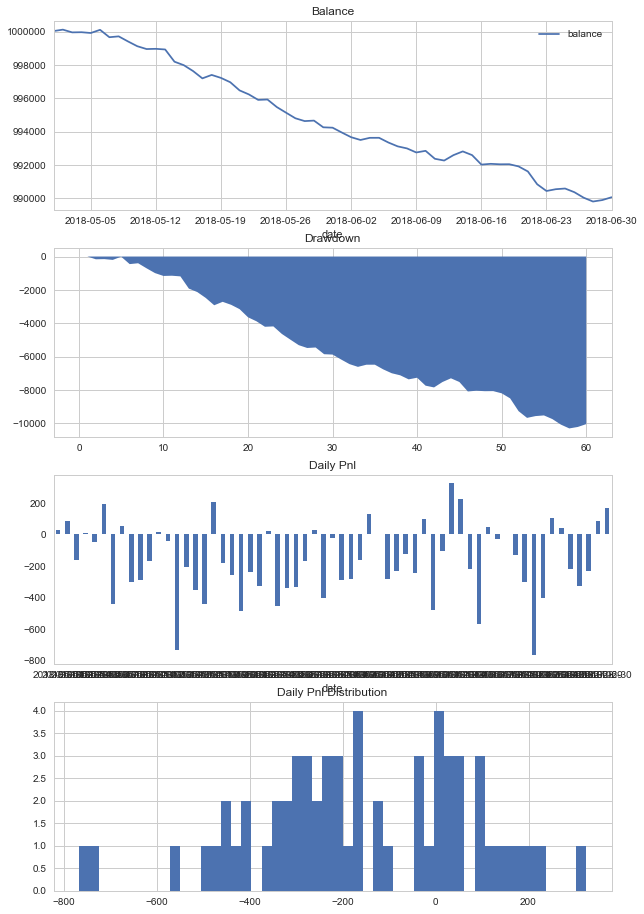

2018-07-14 14:08:51.850338	计算回测结果
2018-07-14 14:08:51.893294	------------------------------
2018-07-14 14:08:51.893294	第一笔交易：	2018-05-01 01:08:00
2018-07-14 14:08:51.893294	最后一笔交易：	2018-06-30 23:59:00
2018-07-14 14:08:51.893294	总交易次数：	512
2018-07-14 14:08:51.893294	总盈亏：	-9,947.67
2018-07-14 14:08:51.893294	最大回撤: 	-10,436.15
2018-07-14 14:08:51.893294	平均每笔盈利：	-19.43
2018-07-14 14:08:51.893294	平均每笔滑点：	0.4
2018-07-14 14:08:51.893294	平均每笔佣金：	15.22
2018-07-14 14:08:51.893294	胜率		15.82%
2018-07-14 14:08:51.893294	盈利交易平均值	112.84
2018-07-14 14:08:51.893294	亏损交易平均值	-44.29
2018-07-14 14:08:51.893294	盈亏比：	2.55


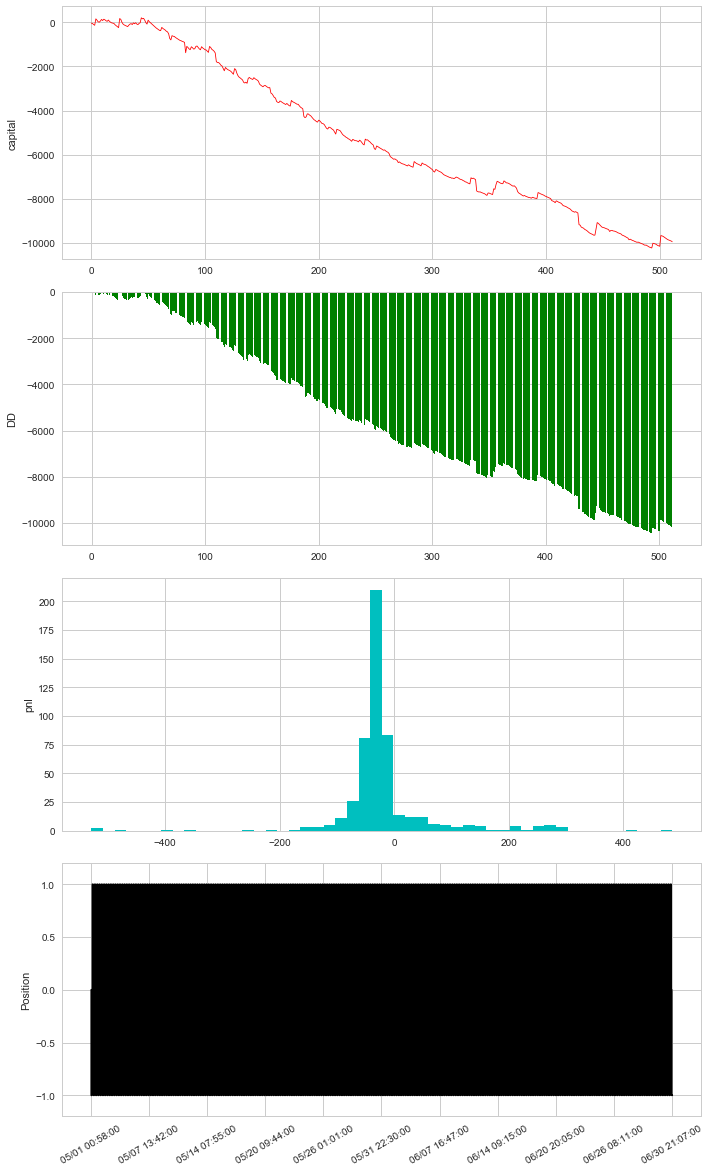

In [8]:
# 显示逐日回测结果
engine.showDailyResult()
# 显示逐笔回测结果
engine.showBacktestingResult()

In [9]:
df = engine.calculateDailyResult()

2018-07-14 14:08:53.791358	计算按日统计结果


In [10]:
df1, result = engine.calculateDailyStatistics(df)

In [11]:
result

{'annualizedReturn': -3.9112475756164065,
 'dailyCommission': 127.63624233483678,
 'dailyNetPnl': -162.96864898401617,
 'dailyReturn': -0.016421105734428478,
 'dailySlippage': 3.3540983606557386,
 'dailyTradeCount': 16.770491803278688,
 'dailyTurnover': 127636.24233483674,
 'endBalance': 990058.912411975,
 'endDate': datetime.date(2018, 6, 30),
 'lossDays': 41,
 'maxDdPercent': -1.0308909493703644,
 'maxDrawdown': -10310.065036893939,
 'profitDays': 20,
 'returnStd': 0.02332927772889488,
 'sharpeRatio': -10.904524310580156,
 'startDate': datetime.date(2018, 5, 1),
 'totalCommission': 7785.810782425044,
 'totalDays': 61,
 'totalNetPnl': -9941.087588024986,
 'totalReturn': -0.9941087588025033,
 'totalSlippage': 204.60000000000005,
 'totalTradeCount': 1023,
 'totalTurnover': 7785810.782425041}